In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('cex4WindDataInterpolated.csv')

# convert time to datetime
df['t'] = pd.to_datetime(df['t'])

# time collumns: t, toy

# target must be float
# df['p'] = df['p'].astype(float)

# variables to use for predictions: Ws, Wd, T

# drop NA
# df.dropna(inplace=True)

# add forward fill
# df.ffill(inplace=True)

df.head()

,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,0.125,1.267,4.9,135.0,275.8,4.9,135.0,275.8,4.9,135.0,275.8
1,1999-01-01 04:00:00,0.167,1.515,5.0,126.9,275.8,5.0,126.9,275.8,5.0,126.9,275.8
2,1999-01-01 05:00:00,0.208,1.915,5.9,135.7,275.5,5.9,135.7,275.5,5.9,135.7,275.5
3,1999-01-01 06:00:00,0.250,1.613,5.3,146.6,275.0,5.3,146.6,275.0,5.3,146.6,275.0
4,1999-01-01 07:00:00,0.292,1.776,6.1,117.4,274.5,5.9,130.2,274.8,5.9,130.2,274.8


In [3]:
import sklearn
from tsai.basics import *
my_setup(sklearn)

os              : macOS-10.16-x86_64-i386-64bit
python          : 3.10.6
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
sklearn         : 1.2.1
torch           : 2.1.2
device          : mps
cpu cores       : 10
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A


In [4]:
datetime_col = "t"
freq = '24h'
columns = df.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df)
df

data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 3.47 MB   
Final memory usage  : 1.88 MB    (-45.8%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,0.125,1.267,4.900000,135.000000,275.799988,4.900000,135.000000,275.799988,4.900000,135.000000,275.799988
1,1999-01-02 03:00:00,1.125,8.152,9.000000,154.300003,273.500000,9.000000,154.300003,273.500000,9.000000,154.300003,273.500000
2,1999-01-03 03:00:00,2.125,9.368,8.100000,183.500000,277.200012,8.100000,183.500000,277.200012,8.100000,183.500000,277.200012
3,1999-01-04 03:00:00,3.125,4.794,8.200000,199.300003,275.399994,8.200000,199.300003,275.399994,8.200000,199.300003,275.399994
4,1999-01-05 03:00:00,4.125,20.201,19.299999,252.500000,278.000000,19.299999,252.500000,278.000000,19.299999,252.500000,278.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2003-04-26 03:00:00,115.125,14.810,13.400000,111.400002,278.100006,13.400000,111.400002,278.100006,13.400000,111.400002,278.100006
1577,2003-04-27 03:00:00,116.125,0.008,2.600000,65.400002,279.799988,2.600000,65.400002,279.799988,2.600000,65.400002,279.799988
1578,2003-04-28 03:00:00,117.125,2.063,6.100000,253.899994,279.799988,6.100000,253.899994,279.799988,6.100000,253.899994,279.799988
1579,2003-04-29 03:00:00,118.125,3.952,8.100000,185.600006,282.799988,8.100000,185.600006,282.799988,8.100000,185.600006,282.799988


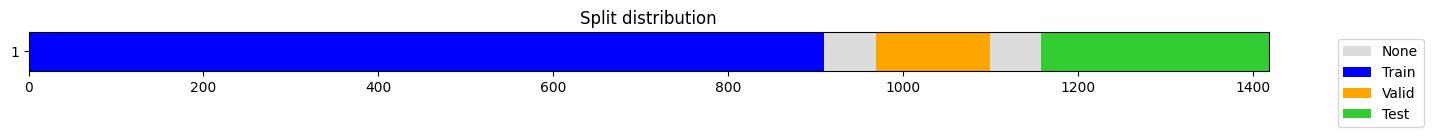

((#910) [0,1,2,3,4,5,6,7,8,9...],
 (#130) [969,970,971,972,973,974,975,976,977,978...],
 (#260) [1158,1159,1160,1161,1162,1163,1164,1165,1166,1167...])

In [5]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

In [6]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,-1.573283,-0.591372,-0.754664,-0.694234,-0.858250,-0.754735,-0.694316,-0.857825,-0.754509,-0.689355,-0.857882
1,1999-01-02 03:00:00,-1.563684,0.680770,0.256933,-0.478781,-1.293281,0.256976,-0.478891,-1.292751,0.257288,-0.474142,-1.292796
2,1999-01-03 03:00:00,-1.554086,0.905451,0.034875,-0.152811,-0.593443,0.034893,-0.152963,-0.593082,0.035186,-0.148535,-0.593146
3,1999-01-04 03:00:00,-1.544487,0.060312,0.059548,0.023569,-0.933907,0.059569,0.023395,-0.933463,0.059864,0.027649,-0.933519
4,1999-01-05 03:00:00,-1.534888,2.907066,2.798260,0.617460,-0.442130,2.798591,0.617208,-0.441805,2.799119,0.620879,-0.441873
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2003-04-26 03:00:00,-0.469445,1.910970,1.342548,-0.957689,-0.423214,1.342715,-0.957737,-0.422893,1.343119,-0.952517,-0.422963
1577,2003-04-27 03:00:00,-0.459846,-0.823998,-1.322145,-1.471203,-0.101672,-1.322280,-1.471184,-0.101428,-1.322102,-1.465459,-0.101506
1578,2003-04-28 03:00:00,-0.450248,-0.444295,-0.458587,0.633088,-0.101672,-0.458624,0.632835,-0.101428,-0.458373,0.636490,-0.101506
1579,2003-04-29 03:00:00,-0.440649,-0.095265,0.034875,-0.129368,0.465762,0.034893,-0.129523,0.465869,0.035186,-0.125118,0.465775


In [7]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [8]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((1418, 11, 104), (1418, 11, 60))

In [9]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [ ]:
learn = TSForecaster(X, y, splits=splits, batch_size=8, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae])

# , cbs=ShowGraph()

: 